# Growth Rate following Stress

In [14]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [199]:
# from http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Q1: What percent difference in growth rate is detectable following stress in 120 min?

**Model:**

Cell growth is given by the exponential equation $n(t) = n_0e^{rt}$ where $r$ is the instaneous growth rate. For diploid yeast, we know the doubling time is roughly 100 min, corresponding to an instaneous growth rate of $\frac{log(2)}{100}$. We are interested in comparing the relative numbers of two exponentially growing populations as a function of time (assuming equal starting concentrations):

\begin{equation}
\frac{n_a(t)}{n_b(t)} = e^{(r_a - r_b)t}
\end{equation}


**Assumptions:**

1. total number of cells is functionally infinite compared to sample being drawn
2. sample size = 20000 (number of events collected per sample per timepoint)
3. equal starting conditions pre-stress (but general conclusions should be independent of this)
4. wild type growth rate following 42&deg;C, 20 min stress is roughly half that of max growth rate in rich media under optimal temperatures.
5. **Population growth rate during recovery (120 min following stress) is constant**

In [166]:
# Use this parameter to set the time limits of the experiment (in min!)
recovery_time = 120

t = np.linspace(0,recovery_time,recovery_time+1)
max_growth = np.log(2) / 100
post_stress_growth = max_growth / 2

percent_differences = np.array([0.01, 0.05, 0.1, .2, .5])
ss = (1-percent_differences)*post_stress_growth - post_stress_growth

# This makes an array of arrays - switch to one array with a row for each condition?
predicted_ratio = np.zeros((len(ss), len(t)))

#print(len(ss))
#print(np.shape(predicted_ratio))

for i, s in enumerate(ss):
    predicted_ratio[i] = np.exp(s*t)

# Convert from odds space to frequency space using r / (1 + r)
predicted_freq = predicted_ratio/(predicted_ratio+1)

### Growth rate simulations

Below is the predicted ratio of slower-growing cells to wild-type cells (growing at half-maximal rate). In this case the slower-growing cells could be the labelled strain which has experienced the same shock/pH conditions as the wild type, in which case we would expect the growth rate differences to be on the order of 1% (0.01). We could also compare to log-growing or natively-shocked wild-type cells, in which case we'd expect the percent difference in growth rate to be larger ? for the former and up to 90% for the latter.

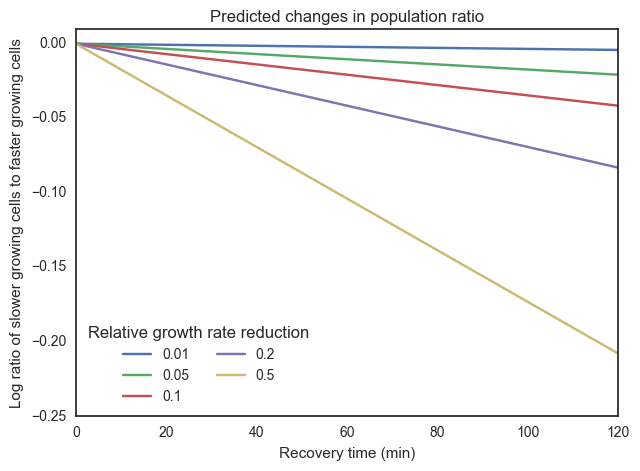

In [168]:
f,ax = plt.subplots(figsize = (7,5))
for i, s in enumerate(predicted_ratio):
    ax.plot(t, np.log(s), label=str(percent_differences[i]))

ax.set_ylim((-.25,.01))
ax.legend(loc = 'lower left', fancybox=True, title = "Relative growth rate reduction", ncol=2)
ax.set_xlabel('Recovery time (min)')
ax.set_ylabel('Log ratio of slower growing cells to faster growing cells')
ax.set_title('Predicted changes in population ratio')
plt.show()

### Modeling Experimental Noise

Now lets add some sampling noise - we'll simulate this by drawing from a binomial distribution with frequency parameter equal to the frequencies given by the above.

**NOTE** The binomial distribution assumes sampling with replacement; however we can make this assumption because the population as a whole is considered to be functionally infinite compared to the sample we are taking.

In [205]:
timepoints = [30, 60, 90, 120]
sample_size = 20000

measured_ratios = []
for i, s in enumerate(ss):
    ratios = []
    for time in timepoints:
        p = predicted_freq[i][time]
        sampled_wt = np.random.binomial(sample_size, p)
        #print(sampled_wt)
        measured_ratio = sampled_wt / (sample_size - sampled_wt)
        #print(measured_ratio)
        ratios.append(measured_ratio)
    measured_ratios.append(ratios)

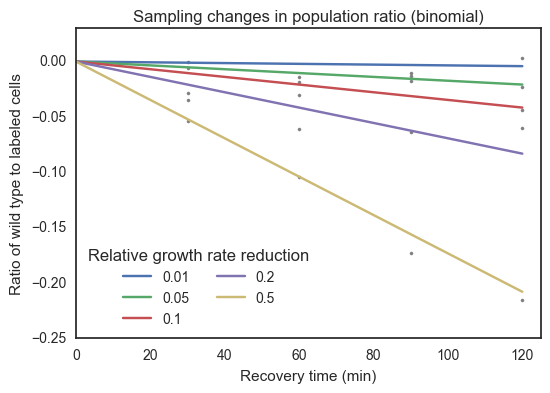

In [176]:
f,ax = plt.subplots(figsize = (6,4))
for i, s in enumerate(predicted_ratio):
    ax.plot(t, np.log(s), label=str(percent_differences[i]))
    ax.scatter(timepoints, np.log(measured_ratios[i]), marker='.', color = 'gray')
    
    
#ax.set_ylim((.9,1.3))
ax.set_xlim((0,125))
ax.set_ylim((-.25,0.03))
ax.legend(loc = 'lower left', fancybox=True, title = "Relative growth rate reduction", ncol=2)
ax.set_xlabel('Recovery time (min)')
ax.set_ylabel('Ratio of wild type to labeled cells')
ax.set_title('Sampling changes in population ratio (binomial)')
plt.show()

It seems pretty clear that we can distinguish large growth defects (50% and 10%) but what about less than 5%? Lets get a handle on the error due to sampling. We'll use the sampling scheme above, and calculate the expected distribution if the measurement is repeated 10 times.

In [184]:
index_lim = [0,2]
small_ss = ss[index_lim[0]:index_lim[1]]
small_freq = predicted_freq[index_lim[0]:index_lim[1]]
small_ratio = predicted_ratio[index_lim[0]:index_lim[1]]

predicted_dists = []
for i, s in enumerate(small_ss):
    ratios = []
    for time in timepoints:
        p = small_freq[i][time]
        sampled_wt = np.random.binomial(sample_size, p, 100)
        measured_ratio = np.log(sampled_wt / (sample_size - sampled_wt))
        ratios.append(measured_ratio)
    predicted_dists.append(ratios)

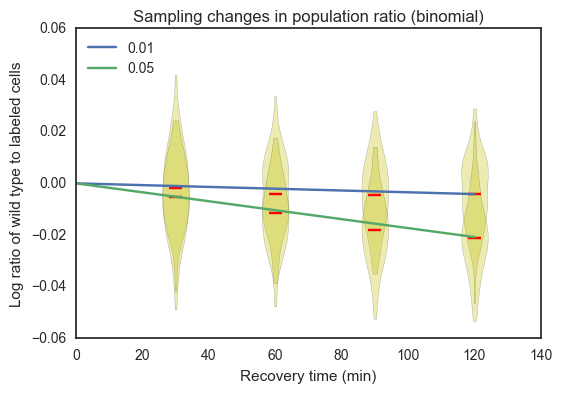

In [185]:
colors = ["black", "grey", "purple"]
f,ax = plt.subplots(figsize = (6,4))
for i, s in enumerate(small_ratio):
    #FIX MANUAL INDEXING OF LABELS
    ax.plot(t, np.log(s), label=str(percent_differences[i]))
    ax.violinplot(predicted_dists[i], positions=timepoints, widths=8, showmedians=True, showextrema=False)

ax.set_xlabel('Recovery time (min)')
ax.set_ylabel('Log ratio of wild type to labeled cells')
ax.set_title('Sampling changes in population ratio (binomial)')
plt.legend(loc='upper left')
plt.show()

0.1% and 1% differences are nearly undetectable during this time period, although the median value for 5% seems reliably higher, enough to potentially measure accurately. This value could also be improved by improving sampling the distribution more; i.e. by recording more events. The trade-off here is that the increased time for sampling increases the amount of time between timepoints.

However, in the current experimental setup it's not possible to make multiple measurements of the same sample (because of the amount of time required to analyze each); it may be possible to address this in the future, but for now lets assume we can only make every measuremnt once and see what optimizations can be made.

### Confidence intervals on binomial data

First I want to look at how the variance of the binomial scales with the probability of success (p) and the number of samples (n). It may be possible to increase the accuracy of our measure simply by optimizing these parameters. The variance of the binomial distribution is given by $np(1-p)$

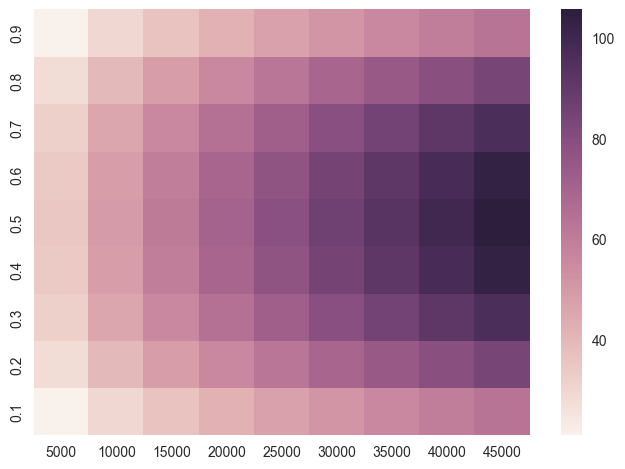

In [10]:
ps = 1-np.arange(0.1, 1, 0.1)
ns = np.arange(5000, 50000, 5000)

vs = []
for p in ps:
    v = ns*p*(1-p)
    vs.append(v)

vs = np.sqrt(np.array(vs))

ax = sns.heatmap(vs, xticklabels=ns, yticklabels=ps)
plt.show()

For any given n, the variance is maximal when the cells are in roughly equal proportion. Will reducing the variance help in getting a more accurate estimate of the ratio between the two populations? *[e.g. instead of mixing the cells 1:1 as I'm currently doing, I mix them 4:1]*


We know that if we have an estimate for $p$, the true frequency of the labeled cells (denoted by $\hat p$), then we can assess a confidence interval for this estimate (based on the assumption of binomially distributed number of "successes"; in this case drawing a labeled cell):

\begin{equation}
    \hat p - z_{\alpha/2}\sqrt{\frac{\hat p \hat q}{n}} \leq p \leq \hat p + z_{\alpha/2}\sqrt{\frac{\hat p \hat q}{n}}
\end{equation}

where 1-$\alpha$ is the confidence level, and $z_{\alpha/2}$ is the z-level on the standard normal at $\frac{\alpha}{2}$.  The ratio $\log\left(\frac{p}{q}\right) = \log{r}$ can be calculated from p; $r = \frac{p}{(1-p)}$.

Now: how to assign a confidence interval for the quantity $\log\left(\frac{p}{q}\right)$?

**Option 1:** Since p absolutely determines q, and the labels can be switched without changing the interpretation of the rates (i.e. "success" can be getting a wild type cell or getting a labeled cell), then I think we can calculate a confidence interval for p - these can be used to calculate corresponding q values, and then a confidence interval for $\log\left(\frac{p}{q}\right)$ can be determined.

*A note from Erik: we are calculating $\log\left(\frac{p}{(1-p)}\right)$, and this function is monotonic with p*

**Option 2:** Simulate the distribution of $\log\left(\frac{p}{q}\right)$ values for a given p, then compare to several known distributions (normal, poisson etc. with known variance) use a chi-square test (or similar) to determine which is the most appropriate fit, and use this model to calculate the variance in the log ratio statistic.

In [75]:
# Note that the equivalent of qnorm in R (which calculates the z values above) is scipy.stats.norm.ppf()

# Simulated experiment:

small_ss # Two different growth rates (small differences)
small_freq # Actual frequencies over time

def calc_ratio_ci(phat, n, alpha):
    """Given an estimated frequency (phat) of a binomially distributed event, return the confidence interval
    on the log of the ratio between the two events. Uses the Wald method; assumes high sampling density;
    1-alpha is the confidence level desired"""
    qhat = 1-phat
    plow = phat - (-stats.norm.ppf(alpha/2)*np.sqrt((phat*qhat)/n))
    phigh = phat + (-stats.norm.ppf(alpha/2)*np.sqrt((phat*qhat)/n))
    return np.log(plow/(1-plow)), np.log(phigh/(1-phigh))
    #return plow, phigh
    #return plow/(1-plow), phigh/(1-phigh)

How does the range of the confidence interval scale with p?

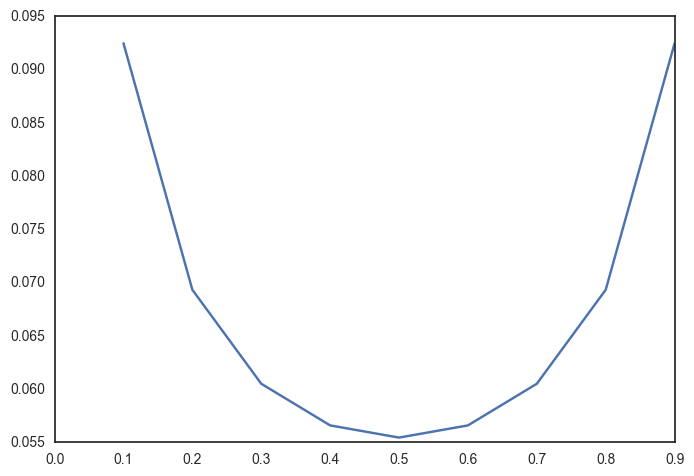

In [76]:
def ci_range(phat, n, alpha):
    return calc_ratio_ci(phat, n, alpha)[1] - calc_ratio_ci(phat, n, alpha)[0]

cis = []
for p in ps:
    cis.append(ci_range(p, 20000, 0.05))
    
    
plt.plot(ps, cis)
plt.show()

The confidence interval on the log ratio of the two quantities is smallest when the two frequencies are close to one another.

Now we can apply this to our model of yeast growth, in order to calculate what percent growth rates we can distinguish between. I'll look at a 1% growth rate difference, and calculate a 95% confidence interval over time for each individual measurement. When the CIs no longer overlap, then we can confidentally distinguish the two conditions.

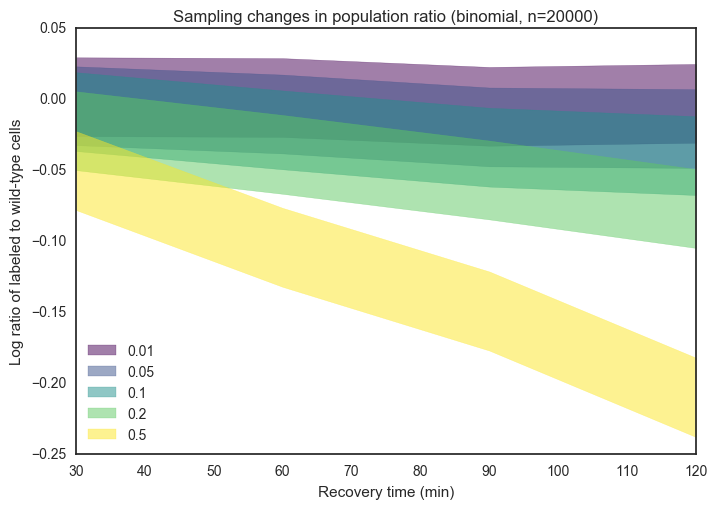

In [211]:
sample_size=20000
measured_ratios = np.asarray(measured_ratios)
measured_freq = measured_ratios / (1+measured_ratios)

measured_cis_low = np.empty_like(measured_freq)
measured_cis_high = np.empty_like(measured_freq)
for i, freq_row in enumerate(measured_freq):
    for j, freq in enumerate(freq_row):
        low, high = calc_ratio_ci(freq, 20000, 0.05)
        measured_cis_high[i,j] = high
        measured_cis_low[i,j] = low


colors = [plt.cm.viridis(x) for x in np.linspace(0, 1, len(measured_freq))]

fig,ax1=plt.subplots()

for i in range(len(measured_freq)):
    ax1.fill_between(timepoints, measured_cis_low[i], measured_cis_high[i], color=colors[i], alpha=0.5,
                    label=str(percent_differences[i]))

ax1.set_xlabel('Recovery time (min)')
ax1.set_ylabel('Log ratio of labeled to wild-type cells')
ax1.set_title("Sampling changes in population ratio (binomial, n={!s})".format(sample_size))
plt.legend(loc="lower left")
plt.show()


**With a higher sample size:**

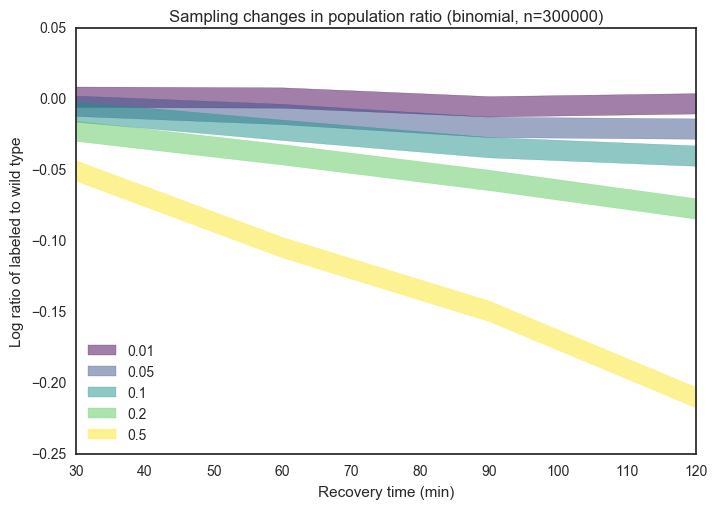

In [209]:
sample_size = 300000

measured_ratios = []
for i, s in enumerate(ss):
    ratios = []
    for time in timepoints:
        p = predicted_freq[i][time]
        sampled_wt = np.random.binomial(sample_size, p)
        measured_ratio = sampled_wt / (sample_size - sampled_wt)
        ratios.append(measured_ratio)
    measured_ratios.append(ratios)

measured_ratios = np.asarray(measured_ratios)
measured_freq = measured_ratios / (1+measured_ratios)

measured_cis_low = np.empty_like(measured_freq)
measured_cis_high = np.empty_like(measured_freq)
for i, freq_row in enumerate(measured_freq):
    for j, freq in enumerate(freq_row):
        low, high = calc_ratio_ci(freq, sample_size, 0.05)
        measured_cis_high[i,j] = high
        measured_cis_low[i,j] = low


colors = [plt.cm.viridis(x) for x in np.linspace(0, 1, len(measured_freq))]

fig,ax1=plt.subplots()

for i in range(len(measured_freq)):
    ax1.fill_between(timepoints, measured_cis_low[i], measured_cis_high[i], color=colors[i], alpha=0.5,
                    label=str(percent_differences[i]))

ax1.set_xlabel('Recovery time (min)')
ax1.set_ylabel('Log ratio of labeled to wild type')
ax1.set_title('Sampling changes in population ratio (binomial, n={!s})'.format(sample_size))
plt.legend(loc="lower left")
plt.show()

This simulation is useful because it demonstrates that if I increase the number of samples (above by a factor of 15) we can detect growth rate differences as small as 1% at the 95% confidence level by 90 minutes of recovery. Modeling growth and our measurement this way also allows us to assign confidence intervals on data I've already taken on a point-by-point basis without making repeated measurements. While taking samples this large might not be necessary in cases where we expect large growth rate differences, I think it's important to demonstrate that we can confidentally detect them if necessary.

### Summary

1. Differences in growth rate can be observed on the timescales of stress recovery
2. These differences can be detected even with one measurement of the data given sufficient sampling (n, number of cells read by the cytometer)
3. The confidence interval of the measure of relevance, $\log\left(\frac{p}{1-p}\right)$, is minimized when p is close to 0.5 (when the cells are mixed at a roughly 50:50 ratio).